In [1]:
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer, models, InputExample, losses, evaluation
import numpy as np
import random
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

CONSTANTS = {
    "VOC_NAMES": ["Alpha", "Beta", "Delta", "Gamma", "Omicron"],
    "LOSS_NAME": "SoftmaxLoss",
    "NEG_SET": "delta", # "other" or "delta"
    "POOLING_MODE": "max",
    "CONCAT": "CD", # "C" for concat-only, "CD" for concat+diff, or "CDM" for concat+diff+mult
    "NUM_LABELS": 2,
    "CONF_THRESHOLD": 0.0,
    "BATCH_SIZE": 32,
    "EPOCHS": 10,
    "LR": 1e-3,
    "RELU": 0.1,
    "DROPOUT": 0.8,
    "MARGIN": None
}

if CONSTANTS["CONF_THRESHOLD"] is not None and CONSTANTS["CONF_THRESHOLD"] > 0: 
    CONSTANTS["NUM_LABELS"] += 1 # for the 'other' class

In [2]:
#word_embedding_model = models.Transformer(model_name_or_path="Rostlab/prot_bert", max_seq_length=1280)

encoder = models.Transformer(model_name_or_path="./mlm_checkpoints/CoV-RoBERTa_2048",
                                          max_seq_length=1280,
                                          tokenizer_name_or_path="tok/")

dim = encoder.get_word_embedding_dimension() # 768

pooler = models.Pooling(dim, pooling_mode = CONSTANTS["POOLING_MODE"])

modules = [encoder, pooler]

if CONSTANTS["RELU"] > 0:
    dense = models.Dense(in_features=dim, out_features=int(dim*CONSTANTS["RELU"]), activation_function=nn.ReLU())
    modules.append(dense)

if CONSTANTS["DROPOUT"] > 0:
    dropout = models.Dropout(CONSTANTS["DROPOUT"])
    modules.append(dropout)

model = SentenceTransformer(modules=modules)

# # Freeze initial transformer layers
# for param in model[0].auto_model.embeddings.parameters():
#     param.requires_grad = False
# for param in model[0].auto_model.encoder.layer[:6].parameters():
#     param.requires_grad = False

print(model)

Some weights of the model checkpoint at ./mlm_checkpoints/CoV-RoBERTa_2048 were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./mlm_checkpoints/CoV-RoBERTa_2048 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

SentenceTransformer(
  (0): Transformer({'max_seq_length': 1280, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': True, 'pooling_mode_global_max': False, 'pooling_mode_global_avg': False, 'pooling_mode_attention': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
  (2): Dropout(
    (dropout_layer): Dropout(p=0.8, inplace=False)
  )
  (3): Dense({'in_features': 768, 'out_features': 192, 'bias': True, 'activation_function': 'torch.nn.modules.activation.ReLU'})
)


# Construct Pairs for Training

In [3]:
omicron_sequences = pd.read_csv("data/unique_Omicron_2k.csv")["sequence"].tolist()
alpha_sequences = pd.read_csv("data/unique_Alpha_2k.csv")["sequence"].tolist()
beta_sequences = pd.read_csv("data/unique_Beta_2k.csv")["sequence"].tolist()
delta_sequences = pd.read_csv("data/unique_Delta_2k.csv")["sequence"].tolist()
gamma_sequences = pd.read_csv("data/unique_Gamma_2k.csv")["sequence"].tolist()

refs = []
seqs = []
labels = []
L = len(omicron_sequences)
if CONSTANTS["NEG_SET"] == "delta":
    for i in range(L):
        steps = [k*L//4 for k in range(1)] # range 1 means only one step, increase for more steps
        positives = [omicron_sequences[(i+step) % L] for step in steps]
        negatives = [delta_sequences[(i+step) % L] for step in steps]
        for neg, pos in zip(negatives, positives):
            refs.append(omicron_sequences[i])
            seqs.append(pos)
            labels.append(0) # 0 means omicron-omicron
            refs.append(omicron_sequences[i])
            seqs.append(neg)
            labels.append(1) # 1 means omicron-delta

elif CONSTANTS["NEG_SET"] == "other":
    NEGS = [delta_sequences, alpha_sequences, beta_sequences, gamma_sequences]
    for i in range(len(omicron_sequences)):
        for n_i, other_sequences in enumerate(NEGS):
            refs.append(omicron_sequences[i])
            seqs.append(omicron_sequences[(i+1) % len(omicron_sequences)])
            labels.append(0) # label = 0 means omicron-omicron
            refs.append(omicron_sequences[i])
            seqs.append(other_sequences[i])
            if CONSTANTS["NUM_LABELS"] == 2:
                labels.append(1) # label = 1 means omicron-other
            else:
                labels.append(n_i + 1) # label > 0 means omicron-other


df = pd.DataFrame({"reference": refs, "sequence": seqs, "label": labels})

examples = []
for i, row in df.iterrows():
    examples.append(InputExample(texts=[row["reference"], row["sequence"]], label=row["label"]))

print("Training set length:", len(examples))

# Split data into train, validation, and test sets
train_size = int(len(examples) * 0.8)
val_size = int(len(examples) * 0.1)
train_examples = examples[:train_size]
val_examples = examples[train_size:train_size + val_size]
test_examples = examples[train_size + val_size:]
# create dataloaders
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=CONSTANTS["BATCH_SIZE"])
val_dataloader = DataLoader(val_examples, shuffle=False, batch_size=CONSTANTS["BATCH_SIZE"])
test_dataloader = DataLoader(test_examples, shuffle=False, batch_size=CONSTANTS["BATCH_SIZE"])

Training set length: 4000


# Generate Pairs for Zero-shot Test

In [4]:
o = pd.read_csv("data/unique_Omicron_2k.csv")["sequence"].tolist()
e = pd.read_csv("data/unique_Eris_2k.csv")["sequence"].tolist()[:2000]
n = pd.read_csv("data/unique_New_2k.csv")["sequence"].tolist()[:2000]

refs = []
seqs = []
labels = []

for i in range(len(omicron_sequences)):
        refs.append(o[i])
        seqs.append(e[i])
        labels.append(CONSTANTS["NUM_LABELS"]-1)
        refs.append(o[i])
        seqs.append(n[i])
        labels.append(0) # 0 means both are omicron
                
df = pd.DataFrame({"reference": refs, "sequence": seqs, "label": labels})

zero_test_examples = []
for i, row in df.iterrows():
    zero_test_examples.append(InputExample(texts=[row["reference"], row["sequence"]], label=row["label"]))

print("Zero-shot test set length: ", len(zero_test_examples))

# create dataloader for zero-shot test set
zero_test_dataloader = DataLoader(zero_test_examples, shuffle=False, batch_size=CONSTANTS["BATCH_SIZE"])

Zero-shot test set length:  4000


# Define Loss

In [5]:
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(),
                                num_labels=CONSTANTS["NUM_LABELS"],
                                conf_threshold=CONSTANTS["CONF_THRESHOLD"],
                                concatenation_sent_rep = True if "C" in CONSTANTS["CONCAT"] else False,
                                concatenation_sent_difference = True if "D" in CONSTANTS["CONCAT"] else False,
                                concatenation_sent_multiplication = True if "M" in CONSTANTS["CONCAT"] else False)

print(train_loss)

SoftmaxLoss(
  (model): SentenceTransformer(
    (0): Transformer({'max_seq_length': 1280, 'do_lower_case': False}) with Transformer model: RobertaModel 
    (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': True, 'pooling_mode_global_max': False, 'pooling_mode_global_avg': False, 'pooling_mode_attention': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
    (2): Dropout(
      (dropout_layer): Dropout(p=0.8, inplace=False)
    )
    (3): Dense({'in_features': 768, 'out_features': 192, 'bias': True, 'activation_function': 'torch.nn.modules.activation.ReLU'})
  )
  (classifier): Linear(in_features=576, out_features=2, bias=True)
  (loss_fct): CrossEntropyLoss()
)


# Construct Evaluators

In [6]:
evaluator = evaluation.LabelAccuracyEvaluator(val_dataloader, softmax_model=train_loss, name="Eval")
test_evaluator = evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss, name="Test")
zero_test_evaluator = evaluation.LabelAccuracyEvaluator(zero_test_dataloader, softmax_model=train_loss, name="Zero")

# Prepare Folders

In [7]:
import os
import shutil

# Create output directory if needed
output_dir = f"./outputs/{CONSTANTS['LOSS_NAME']}_omicron_vs_{CONSTANTS['NEG_SET']}_" \
                f"P{CONSTANTS['POOLING_MODE']}_" \
                f"R{CONSTANTS['RELU']}_" \
                f"D{CONSTANTS['DROPOUT']}_" \
                f"E{CONSTANTS['EPOCHS']}_" \
                f"LR_{CONSTANTS['LR']}_" \
                f"B{CONSTANTS['BATCH_SIZE']}_" \
                f"T{CONSTANTS['CONF_THRESHOLD']}_" \
                f"{CONSTANTS['CONCAT']}"

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
    print(f"Removed directory: {output_dir}")

checkpoint_dir = f"{output_dir}/checkpoints"
stats_dir = f"{output_dir}/stats"

for d in [checkpoint_dir, stats_dir]:
    if not os.path.exists(d):
        os.makedirs(d)
        print(f"Created directory: {d}")

Removed directory: ./outputs/SoftmaxLoss_omicron_vs_delta_Pmax_R0.25_D0.8_E10_LR_0.001_B32_T0.0_CD
Created directory: ./outputs/SoftmaxLoss_omicron_vs_delta_Pmax_R0.25_D0.8_E10_LR_0.001_B32_T0.0_CD/checkpoints
Created directory: ./outputs/SoftmaxLoss_omicron_vs_delta_Pmax_R0.25_D0.8_E10_LR_0.001_B32_T0.0_CD/stats


# Run Training & Test

In [8]:
# print CONSTANTS
for k, v in CONSTANTS.items():
    print(f"{k}: {v}")

model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          tester=test_evaluator,
          zero_shot_tester=zero_test_evaluator,
          epochs=CONSTANTS["EPOCHS"],
          optimizer_params= {'lr': CONSTANTS["LR"]}, # 1e-3 for CoV-RoBERTa, 1e-6 for ProtBERT
          weight_decay=0.1, # 0.1 for CoV-RoBERTa, 0.01 for ProtBERT
          #evaluation_steps=eval_iter,
          output_path=output_dir,
          save_best_model=True,
          #checkpoint_path=checkpoint_dir,
          #checkpoint_save_steps=len(train_dataloader), # save a checkpoint every epoch
          #checkpoint_save_total_limit=10000,
          show_progress_bar=True,
          loss_name=CONSTANTS["LOSS_NAME"])

VOC_NAMES: ['Alpha', 'Beta', 'Delta', 'Gamma', 'Omicron']
LOSS_NAME: SoftmaxLoss
NEG_SET: delta
POOLING_MODE: max
CONCAT: CD
NUM_LABELS: 2
CONF_THRESHOLD: 0.0
BATCH_SIZE: 32
EPOCHS: 10
LR: 0.001
RELU: 0.25
DROPOUT: 0.8
MARGIN: None


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

--- Epoch 0 ---
Train Loss = 0.6801   Train Accuracy = 0.6250
Eval Loss  = 0.6750   Eval Accuracy  = 0.6150
Test Loss  = 0.6747   Test Accuracy  = 0.6300
Zero Loss  = 0.6671   Zero Accuracy  = 0.3510


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

--- Epoch 1 ---
Train Loss = 0.6522   Train Accuracy = 0.6875
Eval Loss  = 0.5716   Eval Accuracy  = 0.6800
Test Loss  = 0.5780   Test Accuracy  = 0.7150
Zero Loss  = 0.6994   Zero Accuracy  = 0.2915


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

--- Epoch 2 ---
Train Loss = 0.3373   Train Accuracy = 0.9375
Eval Loss  = 0.2835   Eval Accuracy  = 0.9075
Test Loss  = 0.2209   Test Accuracy  = 0.8925
Zero Loss  = 0.6423   Zero Accuracy  = 0.5600


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

--- Epoch 3 ---
Train Loss = 0.0422   Train Accuracy = 1.0000
Eval Loss  = 0.1372   Eval Accuracy  = 0.9600
Test Loss  = 0.0401   Test Accuracy  = 0.9425
Zero Loss  = 0.9939   Zero Accuracy  = 0.5700


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

--- Epoch 4 ---
Train Loss = 0.4047   Train Accuracy = 0.9062
Eval Loss  = 0.4670   Eval Accuracy  = 0.9000
Test Loss  = 0.5132   Test Accuracy  = 0.9025
Zero Loss  = 2.1295   Zero Accuracy  = 0.4970


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

--- Epoch 5 ---
Train Loss = 0.4039   Train Accuracy = 0.9375
Eval Loss  = 0.1419   Eval Accuracy  = 0.9550
Test Loss  = 0.2891   Test Accuracy  = 0.9500
Zero Loss  = 0.9833   Zero Accuracy  = 0.7358


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

--- Epoch 6 ---
Train Loss = 0.0007   Train Accuracy = 1.0000
Eval Loss  = 0.0140   Eval Accuracy  = 0.9750
Test Loss  = 0.3975   Test Accuracy  = 0.9625
Zero Loss  = 1.3047   Zero Accuracy  = 0.5105


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

--- Epoch 7 ---
Train Loss = 0.0007   Train Accuracy = 1.0000
Eval Loss  = 0.0067   Eval Accuracy  = 0.9600
Test Loss  = 0.4016   Test Accuracy  = 0.9550
Zero Loss  = 2.0465   Zero Accuracy  = 0.5192


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

--- Epoch 8 ---
Train Loss = 0.0007   Train Accuracy = 1.0000
Eval Loss  = 0.0375   Eval Accuracy  = 0.9575
Test Loss  = 0.4095   Test Accuracy  = 0.9575
Zero Loss  = 3.3009   Zero Accuracy  = 0.4878


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

--- Epoch 9 ---
Train Loss = 0.0004   Train Accuracy = 1.0000
Eval Loss  = 0.0252   Eval Accuracy  = 0.9550
Test Loss  = 0.4659   Test Accuracy  = 0.9475
Zero Loss  = 1.7012   Zero Accuracy  = 0.6515


# Display Stats

In [9]:
# read loss values from csv:
f_train_stats = os.path.join(stats_dir, 'Train.csv')
f_eval_stats = os.path.join(stats_dir, 'Eval.csv')
f_test_stats = os.path.join(stats_dir, 'Test.csv')
f_zero_stats = os.path.join(stats_dir, 'Zero.csv')

train_stats = pd.read_csv(f_train_stats)
eval_stats = pd.read_csv(f_eval_stats)
test_stats = pd.read_csv(f_test_stats)
zero_stats = pd.read_csv(f_zero_stats)

best_test_acc = test_stats["accuracy"].max()
best_zero_acc = zero_stats["accuracy"].max()

# create a dataframe with CONSTANTS and best accuracies
df = pd.DataFrame()
for k, v in CONSTANTS.items():
    if k not in ["VOC_NAMES"]:
        df[k] = [v] # if v is not None else ["N/A"]

df["MAX_TEST_ACC"] = best_test_acc
df["MAX_ZERO_ACC"] = best_zero_acc

display(df)

# save the dataframe to a csv file under stats_dir
df.to_csv(os.path.join(stats_dir, "summary.csv"), index=False)

# append row to global_stats.csv
if not os.path.exists("global_stats.csv") or os.path.getsize("global_stats.csv") == 0:
    df.to_csv("global_stats.csv", index=False)
else:
    global_stats = pd.read_csv("global_stats.csv")
    global_stats = pd.concat([global_stats, df], ignore_index=True)
    global_stats.to_csv("global_stats.csv", index=False)

,LOSS_NAME,NEG_SET,POOLING_MODE,CONCAT,NUM_LABELS,CONF_THRESHOLD,BATCH_SIZE,EPOCHS,LR,RELU,DROPOUT,MARGIN,MAX_TEST_ACC,MAX_ZERO_ACC
0,SoftmaxLoss,delta,max,CD,2,0.0,32,10,0.001,0.25,0.8,None,0.9625,0.7358


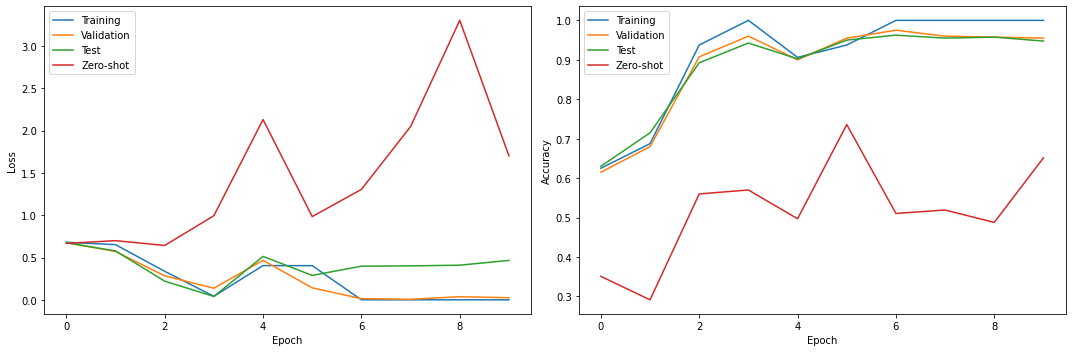

In [10]:
# Plot the training and validation loss and accuracy
import matplotlib.pyplot as plt

# plot loss and accuracy figures side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_stats["epoch"], train_stats["loss"], label="Training")
axs[0].plot(eval_stats["epoch"], eval_stats["loss"], label="Validation")
axs[0].plot(test_stats["epoch"], test_stats["loss"], label="Test")
axs[0].plot(zero_stats["epoch"], zero_stats["loss"], label="Zero-shot")

axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[1].plot(train_stats["epoch"], train_stats["accuracy"], label="Training")
axs[1].plot(eval_stats["epoch"], eval_stats["accuracy"], label="Validation")
axs[1].plot(test_stats["epoch"], test_stats["accuracy"], label="Test")
axs[1].plot(zero_stats["epoch"], zero_stats["accuracy"], label="Zero-shot")

axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
plt.tight_layout()
#save as pdf
plt.savefig(os.path.join(stats_dir, "plot.pdf"))
plt.show()

# Test Run Using Best Model

In [11]:
# # load best model
# best_model = SentenceTransformer(f"{output_dir}/best_model")
# loss_model = losses.SoftmaxLoss(model=best_model, sentence_embedding_dimension=best_model.get_sentence_embedding_dimension(),
#                                 num_labels=CONSTANTS["NUM_LABELS"],
#                                 conf_threshold=CONSTANTS["CONF_THRESHOLD"],
#                                 concatenation_sent_rep = True if "C" in CONSTANTS["CONCAT"] else False,
#                                 concatenation_sent_difference = True if "D" in CONSTANTS["CONCAT"] else False,
#                                 concatenation_sent_multiplication = True if "M" in CONSTANTS["CONCAT"] else False)

# print(loss_model)

# # Load the state dictionary from the file
# state_dict = torch.load(f"{output_dir}/softmax_model_checkpoints/best.pt")

# # Load the state dictionary into the model
# loss_model.load_state_dict(state_dict, strict=True)

# best_model.to("cuda")
# loss_model.to("cuda")

# test_acc = best_model.evaluate(test_evaluator)
# zero_acc = best_model.evaluate(zero_test_evaluator)

# print(f"Test accuracy: {test_acc}")
# print(f"Zero-shot accuracy: {zero_acc}")
